Loading os and trying to use GPU 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0


In [3]:
#base path is the location of the repo on your computer

BASE_PATH = os.path.dirname(os.getcwd())
TRAIN_IMAGE_PATH= os.path.join(BASE_PATH, "Data", "train_images_small")


In [4]:
from sklearn.preprocessing import LabelEncoder

#read the train_images_metadata.csv file
species = pd.read_csv(BASE_PATH + r"\Data\train_images_metadata.csv", index_col=0)

#read the venomous_status_metadata.csv file
venomous = pd.read_csv(BASE_PATH + r"\Data\venomous_status_metadata.csv", index_col=0)

#merging the 2 files, now every row from species contains a column with venomous status
combined_info = species.merge(venomous[["class_id", "MIVS"]], on="class_id", how="left")

#encoded_id is same as class_id, but starts from 0
encoder = LabelEncoder()
combined_info["encoded_id"] = encoder.fit_transform(combined_info["class_id"])

# Find all of the image_paths 
combined_info["image_path"] = combined_info["image_path"].apply(
    lambda img_path: os.path.join(TRAIN_IMAGE_PATH, img_path)
)


num_classes = len(encoder.classes_)
print("combined information example rows")
print(combined_info.head())
print("Number of classes: {}".format(num_classes))

combined information example rows
   observation_id  endemic        binomial_name code  \
0          117940    False       Bitis caudalis   ZA   
1        37280129    False   Amphiesma stolatum   TH   
2        27445689    False        Lachesis muta   BR   
3        68796818     True         Vipera berus   NL   
4        68796816    False  Coronella austriaca   NL   

                                          image_path  class_id  MIVS  \
0  c:\Users\avark\Documents\snek\src\Data\train_i...       157     0   
1  c:\Users\avark\Documents\snek\src\Data\train_i...        66     0   
2  c:\Users\avark\Documents\snek\src\Data\train_i...       857     1   
3  c:\Users\avark\Documents\snek\src\Data\train_i...      1736     1   
4  c:\Users\avark\Documents\snek\src\Data\train_i...       387     0   

   encoded_id  
0           9  
1           3  
2         126  
3         284  
4          49  
Number of classes: 296


In [5]:
# If species name or latin name column exists (say it's 'species_name')
# get one name per encoded_id, sorted by id so indices line up
CLASS_NAMES = (
    combined_info[['encoded_id', 'binomial_name']]
    .drop_duplicates(subset=['encoded_id'])
    .sort_values('encoded_id')['binomial_name']
    .tolist()
)

print(len(CLASS_NAMES), "classes")
print(CLASS_NAMES[:5]) 

296 classes
['Ahaetulla mycterizans', 'Ahaetulla prasina', 'Aipysurus laevis', 'Amphiesma stolatum', 'Anilius scytale']


Loading python images from folder

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

IMAGE_RESOLUTION=28

# Create a TensorFlow dataset for image loading
def load_img(path):
    img = tf.io.read_file(path)

    #expand_animations = False needed, otherwise gif format isnt proper
    img = tf.image.decode_image(img, channels=3, expand_animations = False)  
    img = tf.image.resize(img, [IMAGE_RESOLUTION, IMAGE_RESOLUTION])
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [7]:
# Labels are going to be either venomous, or non-venomous
species_labels = combined_info['encoded_id']
venom_labels = combined_info['MIVS']

BATCH_SIZE=32


def make_dataset(info_df, batch_size=BATCH_SIZE, shuffle=False):

    image_paths  = info_df["image_path"].values
    sp     = info_df["encoded_id"].values.astype(np.int32)
    ve     = info_df["MIVS"].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, sp, ve))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(info_df), 10_000),
                        seed=42, reshuffle_each_iteration=True)

    def _load(path, species, venom):
        img = load_img(path)  # [0,1] float32
        labels = {"species": species, "venom": venom}
        return img, labels

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [8]:
from sklearn.model_selection import train_test_split

train_info = combined_info.copy()

labels_species = combined_info['encoded_id'].values

#1. split train: 80% train, 20% validation

train_info, temp_info = train_test_split(
    combined_info, test_size=0.2, random_state=42, stratify=combined_info["encoded_id"]
)

# 2: split validation: 10% validation, 10% test
val_info, test_info = train_test_split(
    temp_info, test_size=0.5, random_state=42, stratify=temp_info["encoded_id"]
)


train_dataset = make_dataset(train_info, shuffle=True)
val_dataset   = make_dataset(val_info)
test_dataset  = make_dataset(test_info)

In [9]:
#insanity check, im losing my mind
images_b, labels_b = next(iter(train_dataset))
print(images_b.shape)                 # (32, Height, Width, Channels)
print(labels_b["species"].shape)      # (32,)
print(labels_b["venom"].shape)        # (32,)
print(images_b.dtype)                


(32, 28, 28, 3)
(32,)
(32,)
<dtype: 'float32'>


In [10]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras import Model

from re import X

input = Input(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3))
#x = Rescaling(1./255)(input)

x = Conv2D(32, (3,3), padding='same', activation="relu")(input)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(64, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(128, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.3)(x)

species_output = Dense(num_classes, activation='softmax', name='species')(x)
venom_output = Dense(1, activation='sigmoid', name='venom')(x)

model = Model(inputs=input, outputs=[species_output, venom_output])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 32)  │     36,896 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 296)       │     38,184 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ venom (Dense)       │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,681 (674.54 KB)

 Trainable params: 172,681 (674.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    
    loss={'species': 'sparse_categorical_crossentropy',
          'venom': 'binary_crossentropy'},

    metrics={'species': 'accuracy',
             'venom': 'accuracy'}
    )

In [12]:
n_epochs = 10  # number of epochs to train the neural network
# checkpointing based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# model training
model_history = model.fit(
                            x= train_dataset,
                            epochs= n_epochs,
                            validation_data= val_dataset,
                            callbacks=[model_checkpoint_callback])

model.load_weights('model.keras')  # load weights back

Epoch 1/10
1660/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0023 - species_accuracy: 0.0249 - species_loss: 5.4897 - venom_accuracy: 0.7987 - venom_loss: 0.5125
Epoch 1: val_loss improved from None to 5.81509, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 5.9285 - species_accuracy: 0.0291 - species_loss: 5.4228 - venom_accuracy: 0.7999 - venom_loss: 0.5058 - val_loss: 5.8151 - val_species_accuracy: 0.0325 - val_species_loss: 5.3172 - val_venom_accuracy: 0.7998 - val_venom_loss: 0.4982
Epoch 2/10
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8165 - species_accuracy: 0.0358 - species_loss: 5.3136 - venom_accuracy: 0.7993 - venom_loss: 0.5029
Epoch 2: val_loss improved from 5.81509 to 5.76525, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 5.7968 - species_accuracy: 0.0362 - species_loss: 5.2957 - venom_accuracy: 0.7999 - venom_loss: 0.5011 - val_loss: 5.7653 - val_species_accuracy: 0.0385 - val_species_loss

In [13]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.5400 - species_accuracy: 0.0563 - species_loss: 5.0582 - venom_accuracy: 0.8014 - venom_loss: 0.4815
Test Loss:  5.539963722229004
Test Accuracy:  5.058150768280029


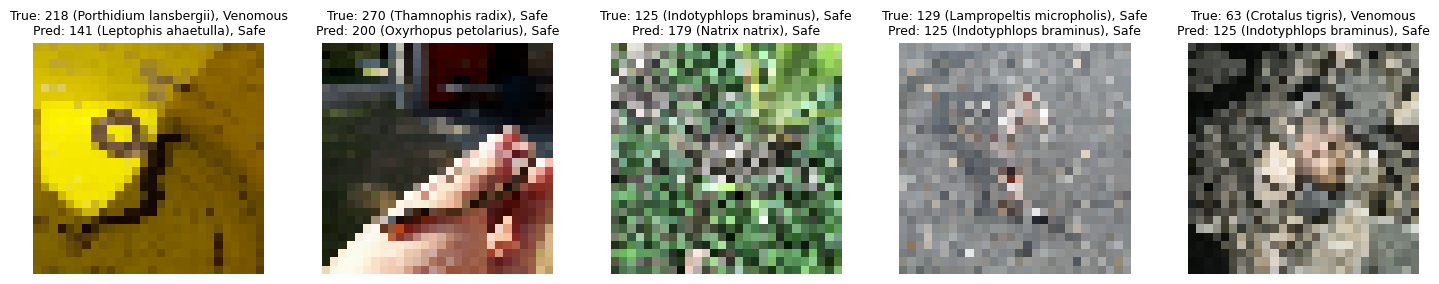

In [49]:
import numpy as np

import tensorflow as tf

def example_results(model, info_df, class_names, venom_threshold=0.5):

    random_indices = np.random.choice(len(info_df), size=5, replace=False)

    plt.figure(figsize=(18, 3))

    for i, idx in enumerate(random_indices):

        image_path   = info_df["image_path"].iloc[idx]
        true_species = info_df["encoded_id"].iloc[idx]
        true_venom   = info_df["MIVS"].iloc[idx]

        img = load_img(image_path)                
        img_dim_expended = tf.expand_dims(img, axis=0) #as if batch size was 1

        #prediction, and then deciding
        species_pred, venom_pred = model.predict(img_dim_expended, verbose=0)
        pred_species = int(np.argmax(species_pred[0]))
        pred_venom   = bool(venom_pred[0, 0] > venom_threshold)

        # resolve names (if provided)
        true_species_name = class_names[true_species] if class_names and 0 <= true_species < len(class_names) else str(true_species)
        pred_species_names = class_names[pred_species] if class_names and 0 <= pred_species < len(class_names) else str(pred_species)

        # plot
        plt.subplot(1, 5, i+1)
        plt.imshow(img.numpy()) 
        plt.axis('off')
        plt.title(
            f"True: {true_species} ({true_species_name}), {'Venomous' if true_venom else 'Safe'}\n"
            f"Pred: {pred_species} ({pred_species_names}), {'Venomous' if pred_venom else 'Safe'}",
            fontsize=9
        )

    plt.show()

example_results(model, test_info, class_names=CLASS_NAMES)
